In [1]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC

import seaborn as sn
import matplotlib.pyplot as plt
import pandas as pd
import os


path = '/home/samuel/Dev/Python/Neural Networks/rn-cin-covid'
os.chdir(path)


In [2]:
def evaluate_svm(model, X_test, y_test):
    
    y_pred = model.predict(X_test)
    
    print("Acurácia teste: ", accuracy_score(y_test, y_pred))
    print("   ")
    
    print(classification_report(y_test, y_pred))
    
    df_cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize = (10,7))
    sn.heatmap(df_cm, annot=True, fmt='.3g')
    plt.show()

In [3]:
def train_predict_SVM(df_total, test):
    # Train
    y = df_total[0]
    X = df_total.drop(0, axis=1)

    y = y.to_numpy()
    X = X.to_numpy()
    
    #Test
    y_test = test[0]
    X_test = test.drop(0, axis=1)

    y_test = y_test.to_numpy()
    X_test = X_test.to_numpy()
    
    # Grid
    # k_range = list(range(1,30))
    # weight_options = ["uniform", "distance"][]
    param_grid = {
        'gamma': [0.0001, 0.001, 0.01, 0.0005, 0.005, 0.05, 0.1, 0.5], 
        'degree': [1, 2, 3, 4, 5, 6, 7, 8], 
        'C': [0.0001, 0.001, 0.01, 0.0005, 0.005, 0.05, 0.1, 0.5, 1, 10, 100, 1000],      
        'kernel': ['linear', 'rbf', 'poly']
    } 

    # param_grid = dict(n_neighbors = k_range, weights = weight_options)
    #print (param_grid)
    svc = SVC()
    folds = 10
    skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 999)
    
    grid = GridSearchCV(svc, param_grid, cv = skf, scoring = 'accuracy')
    grid.fit(X,y)

    #print(grid.grid_scores_)
    '''
    print(grid.grid_scores_[0].parameters)
    print(grid.grid_scores_[0].cv_validation_scores)
    print(grid.grid_scores_[0].mean_validation_score)
    '''

    print ("Best Score: ", grid.best_score_)
    print ("Best params: ", grid.best_params_)
    print("\n")
    
    evaluate_svm(grid.best_estimator_, X_test, y_test)
    return grid.best_params_ 

In [8]:
def treina_melhor_modelo(df_total,test,best_params,base_name):
    y = df_total[0]
    X = df_total.drop(0, axis=1)

    y = y.to_numpy()
    X = X.to_numpy()

    test_true_x = test.drop(0, axis=1).to_numpy()
    test_true_y = test[0].to_numpy()

    svc = SVC(gamma=best_params['gamma'], degree=best_params['degree'], C=best_params['C'], kernel=best_params['kernel'])
    svc_results = pd.DataFrame(columns=["base", "acuracia-teste", "precision-covid-teste", "recall-covid-teste", "f1-covid-teste", "precision-non-covid-teste", "recall-non-covid-teste", "f1-non-covid-teste", "conf-matrix-teste", "acuracia-val", "precision-covid-val", "recall-covid-val", "f1-covid-val", "precision-non-covid-val", "recall-non-covid-val", "f1-non-covid-val", "conf-matrix-val"])

    folds = 30

    skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 999)
    StratifiedKFold(n_splits=2, random_state=None, shuffle=False)


    acuracia_test = []
    acuracia_val = []
    pre_covid_t = []
    re_covid_t = []
    f1_covid_t = []
    pre_ncovid_t = []
    re_ncovid_t = []
    f1_ncovid_t = []
    pre_covid_v = []
    re_covid_v = []
    f1_covid_v = []
    pre_ncovid_v = []
    re_ncovid_v = []
    f1_ncovid_v = []
    base = []
    conf_matrix_val = []
    conf_matrix_test = []





    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        svc.fit(X_train, y_train)
        y_pred = svc.predict(X_test)
        y_pred_true = svc.predict(test_true_x) 




        df_cm = confusion_matrix(y_test, y_pred)
        df_cm_test = confusion_matrix(test_true_y, y_pred_true)   
        class_repo = classification_report(y_test, y_pred, output_dict=True)
        class_repo_test = classification_report(test_true_y, y_pred_true, output_dict=True)

        base.append(base_name)
        acuracia_test.append(accuracy_score(test_true_y, y_pred_true))
        acuracia_val.append(accuracy_score(y_test, y_pred))

        pre_covid_t.append(class_repo_test['1']["precision"])
        re_covid_t.append(class_repo_test['1']["recall"])
        f1_covid_t.append(class_repo_test['1']["f1-score"])
        pre_ncovid_t.append(class_repo_test['0']["precision"])
        re_ncovid_t.append(class_repo_test['0']["recall"])
        f1_ncovid_t.append(class_repo_test['0']["f1-score"])

        pre_covid_v.append(class_repo['1']["precision"])
        re_covid_v.append(class_repo['1']["recall"])
        f1_covid_v.append(class_repo['1']["f1-score"])
        pre_ncovid_v.append(class_repo['0']["precision"])
        re_ncovid_v.append(class_repo['0']["recall"])
        f1_ncovid_v.append(class_repo['0']["f1-score"])

        conf_matrix_val.append(df_cm)
        conf_matrix_test.append(df_cm_test)


    svc_results["acuracia-teste"] = acuracia_test
    svc_results["acuracia-val"] = acuracia_val 
    svc_results["precision-covid-teste"] = pre_covid_t 
    svc_results["recall-covid-teste"] = re_covid_t 
    svc_results["f1-covid-teste"] = f1_covid_t 
    svc_results["precision-non-covid-teste"] = pre_ncovid_t
    svc_results["recall-non-covid-teste"] = re_ncovid_t 
    svc_results["f1-non-covid-teste"] = f1_ncovid_t 
    svc_results["precision-covid-val"] = pre_covid_v 
    svc_results["recall-covid-val"] = re_covid_v 
    svc_results["f1-covid-val"] = f1_covid_v 
    svc_results["precision-non-covid-val"] = pre_ncovid_v 
    svc_results["recall-non-covid-val"] = re_ncovid_v 
    svc_results["f1-non-covid-val"] = f1_ncovid_v 
    svc_results["base"] = base 
    svc_results["conf-matrix-val"] = conf_matrix_val
    svc_results["conf-matrix-teste"] = conf_matrix_test 
    
    return(svc_results)

### Densenet Normal


(5394, 1025)
Best Score:  0.9831282209853638
Best params:  {'C': 0.1, 'degree': 2, 'gamma': 0.001, 'kernel': 'poly'}


Acurácia teste:  0.9207161125319693
   
              precision    recall  f1-score   support

           0       0.79      0.93      0.86       100
           1       0.97      0.92      0.95       291

    accuracy                           0.92       391
   macro avg       0.88      0.92      0.90       391
weighted avg       0.93      0.92      0.92       391



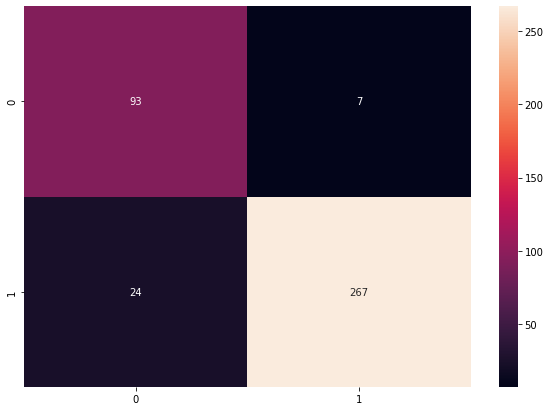

In [9]:
test = pd.read_csv("output/output_densenet_test_retrained.csv", header=None)
train = pd.read_csv("output/output_densenet_train_retrained.csv", header=None)
val = pd.read_csv("output/output_densenet_val_retrained.csv", header=None)

df_total = pd.concat([train,val])
print(df_total.shape)


best_params = train_predict_SVM(df_total, test)

In [10]:
test = pd.read_csv("output/output_densenet_test_retrained.csv", header=None)
train = pd.read_csv("output/output_densenet_train_retrained.csv", header=None)
val = pd.read_csv("output/output_densenet_val_retrained.csv", header=None)

df_total = pd.concat([train,val])

results = treina_melhor_modelo(df_total, test, best_params, "densenet")

### Densenet Augmentation


(10788, 1025)
Best Score:  0.9735816679018056
Best params:  {'C': 0.01, 'degree': 1, 'gamma': 0.001, 'kernel': 'linear'}


Acurácia teste:  0.907928388746803
   
              precision    recall  f1-score   support

           0       0.74      0.98      0.84       100
           1       0.99      0.88      0.93       291

    accuracy                           0.91       391
   macro avg       0.87      0.93      0.89       391
weighted avg       0.93      0.91      0.91       391



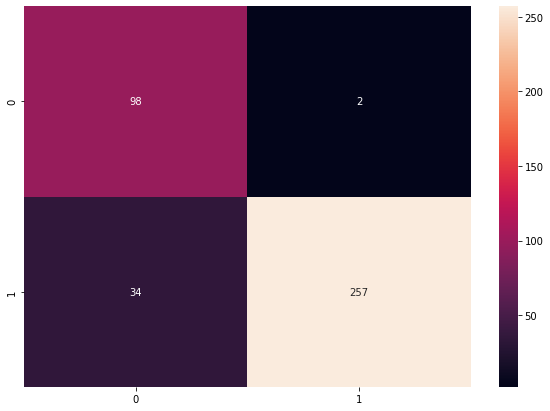

In [11]:
test = pd.read_csv("output/output_densenet_gauss_test_retrained.csv", header=None)
train = pd.read_csv("output/output_densenet_gauss_train_retrained.csv", header=None)
val = pd.read_csv("output/output_densenet_gauss_val_retrained.csv", header=None)

df_total = pd.concat([train,val])
print(df_total.shape)


best_params = train_predict_SVM(df_total, test)


In [12]:
test = pd.read_csv("output/output_densenet_gauss_test_retrained.csv", header=None)
train = pd.read_csv("output/output_densenet_gauss_train_retrained.csv", header=None)
val = pd.read_csv("output/output_densenet_gauss_val_retrained.csv", header=None)

df_total = pd.concat([train,val])

results = pd.concat([results,treina_melhor_modelo(df_total, test, best_params, "densenet_gauss")])

### MobileNet Normal

(5394, 1281)
Best Score:  0.9575434618291763
Best params:  {'C': 0.01, 'degree': 1, 'gamma': 0.001, 'kernel': 'linear'}


Acurácia teste:  0.887468030690537
   
              precision    recall  f1-score   support

           0       0.72      0.93      0.81       100
           1       0.97      0.87      0.92       291

    accuracy                           0.89       391
   macro avg       0.84      0.90      0.86       391
weighted avg       0.91      0.89      0.89       391



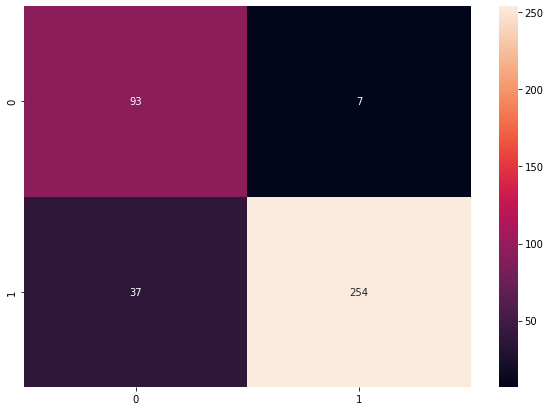

In [13]:
test = pd.read_csv("output/output_mobilenet_test_retrained.csv", header=None)
train = pd.read_csv("output/output_mobilenet_train_retrained.csv", header=None)
val = pd.read_csv("output/output_mobilenet_val_retrained.csv", header=None)

df_total = pd.concat([train,val])
print(df_total.shape)


best_params = train_predict_SVM(df_total, test)

In [14]:
test = pd.read_csv("output/output_mobilenet_test_retrained.csv", header=None)
train = pd.read_csv("output/output_mobilenet_train_retrained.csv", header=None)
val = pd.read_csv("output/output_mobilenet_val_retrained.csv", header=None)

df_total = pd.concat([train,val])

results = pd.concat([results,treina_melhor_modelo(df_total, test, best_params, "mobilenet")])

### MobileNet Augmentation

In [15]:
test = pd.read_csv("output/output_mobilenet_gauss_test_retrained.csv", header=None)
train = pd.read_csv("output/output_mobilenet_gauss_train_retrained.csv", header=None)
val = pd.read_csv("output/output_mobilenet_gauss_val_retrained.csv", header=None)

df_total = pd.concat([train,val])
print(df_total.shape)


best_params = train_predict_SVM(df_total, test)

(10788, 1281)


In [ ]:
test = pd.read_csv("output/output_mobilenet_gauss_test_retrained.csv", header=None)
train = pd.read_csv("output/output_mobilenet_gauss_train_retrained.csv", header=None)
val = pd.read_csv("output/output_mobilenet_gauss_val_retrained.csv", header=None)

df_total = pd.concat([train,val])

results = pd.concat([results,treina_melhor_modelo(df_total, test, best_params, "mobilenet_gauss")])

### VGG16 Normal

In [ ]:
test = pd.read_csv("output/output_vgg16_test_retrained.csv", header=None)
train = pd.read_csv("output/output_vgg16_train_retrained.csv", header=None)
val = pd.read_csv("output/output_vgg16_val_retrained.csv", header=None)

df_total = pd.concat([train,val])
print(df_total.shape)


best_params = train_predict_SVM(df_total, test)

In [ ]:
test = pd.read_csv("output/output_vgg16_test_retrained.csv", header=None)
train = pd.read_csv("output/output_vgg16_train_retrained.csv", header=None)
val = pd.read_csv("output/output_vgg16_val_retrained.csv", header=None)

df_total = pd.concat([train,val])

results = pd.concat([results,treina_melhor_modelo(df_total, test, best_params, "vgg16")])

### VGG16 Augmentation

In [ ]:
test = pd.read_csv("output/output_vgg16_gauss_test_retrained.csv", header=None)
train = pd.read_csv("output/output_vgg16_gauss_train_retrained.csv", header=None)
val = pd.read_csv("output/output_vgg16_gauss_val_retrained.csv", header=None)

df_total = pd.concat([train,val])
print(df_total.shape)


best_params = train_predict_SVM(df_total, test)

In [ ]:
test = pd.read_csv("output/output_vgg16_gauss_test_retrained.csv", header=None)
train = pd.read_csv("output/output_vgg16_gauss_train_retrained.csv", header=None)
val = pd.read_csv("output/output_vgg16_gauss_val_retrained.csv", header=None)

df_total = pd.concat([train,val])

results = pd.concat([results,treina_melhor_modelo(df_total, test, best_params, "vgg16_gauss")])

In [ ]:
results

In [ ]:
results.to_csv('svm-results.csv', header=False, index=False, sep=',', encoding='utf-8')